<a href="https://colab.research.google.com/github/Tanishq200307/mini-project-2/blob/main/02_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    f1_score
)

from imblearn.over_sampling import SMOTE


Load Dataset & Define Target

In [60]:
df = pd.read_csv("loan_prediction.csv")
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Separate Features & Target

In [61]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"].map({"Y": 1, "N": 0})


Data Preprocessing

In [62]:
# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Impute numerical columns with median
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Impute categorical columns with mode
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Confirm no missing values remain
X.isnull().sum().sum()


np.int64(0)

Encode Categorical Variables

In [63]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,Loan_ID_LP001011,...,Loan_ID_LP002990,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,128.0,360.0,1.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,4583,1508.0,128.0,360.0,1.0,True,False,False,False,False,...,False,True,True,True,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,False,True,False,False,False,...,False,True,True,False,False,False,False,True,False,True
3,2583,2358.0,120.0,360.0,1.0,False,False,True,False,False,...,False,True,True,False,False,False,True,False,False,True
4,6000,0.0,141.0,360.0,1.0,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True


Train/Test Split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((491, 627), (123, 627))

Feature Scaling

In [65]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Define Baseline Models

In [66]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=3000,
        solver="lbfgs"
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True)
}


Train & Evaluate Baseline Models

In [67]:
results = []

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

    print(f"\n{name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))



Logistic Regression
Confusion Matrix:
[[20 18]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.95      0.53      0.68        38
           1       0.82      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123


Decision Tree
Confusion Matrix:
[[22 16]
 [ 8 77]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.83      0.91      0.87        85

    accuracy                           0.80       123
   macro avg       0.78      0.74      0.76       123
weighted avg       0.80      0.80      0.80       123


SVM
Confusion Matrix:
[[ 0 38]
 [ 0 85]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.69      1.00      0.82        85

    accuracy                  

Baseline Model Comparison

In [68]:
results_df = pd.DataFrame(results)
results_df


,Model,F1 Score,ROC AUC
0,Logistic Regression,0.898396,0.841796
1,Decision Tree,0.865169,0.742415
2,SVM,0.817308,0.829102


Class Weights

In [69]:
lr_balanced = LogisticRegression(
    max_iter=3000,
    class_weight="balanced"
)

lr_balanced.fit(X_train_scaled, y_train)

y_pred_bal = lr_balanced.predict(X_test_scaled)
y_prob_bal = lr_balanced.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_bal))


Confusion Matrix:
[[21 17]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

ROC AUC: 0.8408668730650154


SMOTE

In [70]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(max_iter=3000)
lr_smote.fit(X_train_sm, y_train_sm)

y_pred_sm = lr_smote.predict(X_test_scaled)
y_prob_sm = lr_smote.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_sm))


Confusion Matrix:
[[21 17]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123

ROC AUC: 0.8445820433436533


Hyperparameter Tuning — Decision Tree (GridSearchCV)

In [71]:
param_grid = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(
    DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    param_grid,
    scoring="f1",
    cv=5
)

grid.fit(X_train, y_train)
grid.best_params_


{'max_depth': 5, 'min_samples_split': 5}

Best Model Evaluation

In [72]:
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_best))


Confusion Matrix:
[[22 16]
 [11 74]]
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        38
           1       0.82      0.87      0.85        85

    accuracy                           0.78       123
   macro avg       0.74      0.72      0.73       123
weighted avg       0.77      0.78      0.78       123

ROC AUC: 0.7433436532507741


ROC Curve — Best Model

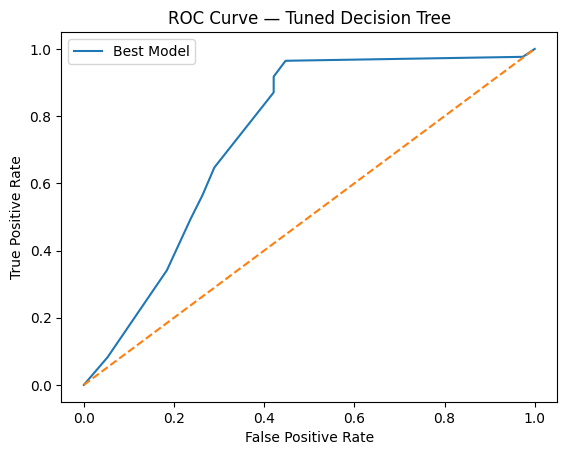

In [73]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best)

plt.figure()
plt.plot(fpr, tpr, label="Best Model")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Tuned Decision Tree")
plt.legend()
plt.show()
